# KMeans

In [109]:
import warnings

import datetime as dt

from operator import attrgetter

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score, silhouette_score

import squarify

from mlxtend.frequent_patterns import apriori

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer


warnings.filterwarnings("ignore")

In [110]:
data = pd.read_csv('clean-data.csv',sep=',')
data.head()

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,0,10.53,Crackers,7500,Prestasi Utama,Prestasi,General Trade
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,1,0.18,Crackers,7500,Prestasi Utama,Prestasi,General Trade
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,0,4.36,Crackers,7500,Prestasi Utama,Prestasi,General Trade
3,TR4331,335,2022-08-01,P3,7500,3,22500,12,29,1,1,4.74,Crackers,7500,Prestasi Utama,Prestasi,General Trade
4,TR6445,181,2022-10-01,P3,7500,4,30000,12,33,1,0,9.94,Crackers,7500,Prestasi Utama,Prestasi,General Trade


In [111]:
data['date'] = pd.to_datetime(data['date'])
data['qty'] = data['qty'].map(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transactionid   5020 non-null   object        
 1   customerid      5020 non-null   int64         
 2   date            5020 non-null   datetime64[ns]
 3   productid       5020 non-null   object        
 4   price_cust      5020 non-null   int64         
 5   qty             5020 non-null   float64       
 6   totalamount     5020 non-null   int64         
 7   storeid         5020 non-null   int64         
 8   age             5020 non-null   int64         
 9   gender          5020 non-null   int64         
 10  marital_status  5020 non-null   int64         
 11  income          5020 non-null   float64       
 12  product_name    5020 non-null   object        
 13  price_prod      5020 non-null   int64         
 14  storename       5020 non-null   object        
 15  grou

In [112]:
data.isnull().sum()

transactionid     0
customerid        0
date              0
productid         0
price_cust        0
qty               0
totalamount       0
storeid           0
age               0
gender            0
marital_status    0
income            0
product_name      0
price_prod        0
storename         0
groupstore        0
type              0
dtype: int64

In [113]:
data.isna().values.any()

False

In [114]:
data[data.duplicated()]

,transactionid,customerid,date,productid,price_cust,qty,totalamount,storeid,age,gender,marital_status,income,product_name,price_prod,storename,groupstore,type


[]

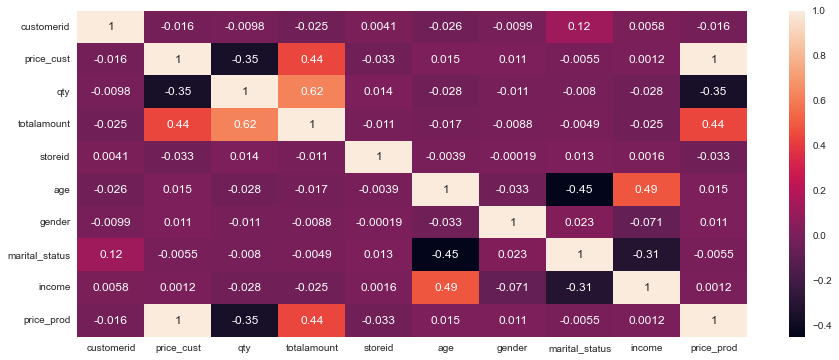

In [115]:
plt.figure(figsize=(15,6))
sns.heatmap(data.corr(),annot=True)
plt.plot()

In [116]:
df_clust = data.groupby("customerid").agg(
    {"transactionid": "count", "qty": "sum", "totalamount": "sum"}
)

df_clust.head()

,transactionid,qty,totalamount
customerid,,,
1,17,60.0,623300
2,13,57.0,392300
3,15,56.0,446200
4,10,46.0,302500
5,7,27.0,268600


In [117]:
print(df_clust.shape)

(447, 3)


In [118]:
df_clust.describe()

,transactionid,qty,totalamount
count,447.000000,447.000000,447.000000
mean,11.230425,40.930649,362512.304251
std,3.245302,12.756679,124634.279184
min,3.000000,10.000000,92100.000000
25%,9.000000,32.000000,271750.000000
50%,11.000000,40.000000,354200.000000
75%,14.000000,50.000000,441200.000000
max,21.000000,79.000000,846700.000000


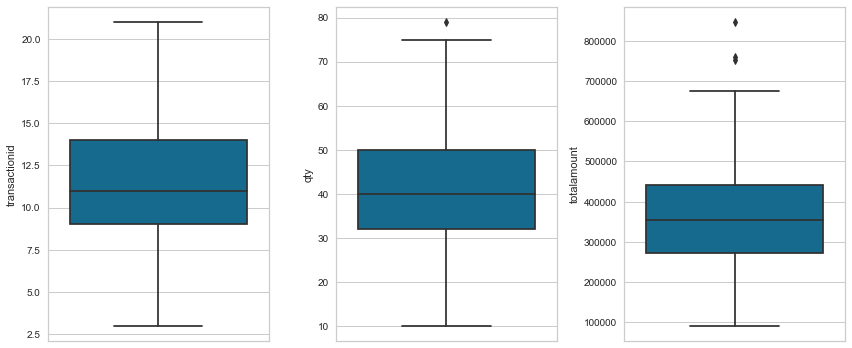

In [119]:
features = df_clust.columns
fig, ax = plt.subplots(1, len(df_clust.columns), figsize=(12, 5))
for i in range(0, len(df_clust.columns)):
    sns.boxplot(data=df_clust, y=features[i], ax=ax[i])
plt.tight_layout()
plt.show()

In [120]:
X = df_clust.values
X_std = StandardScaler().fit_transform(X)
df_std = pd.DataFrame(data=X_std, columns=df_clust.columns)
df_std.isna().sum()

transactionid    0
qty              0
totalamount      0
dtype: int64

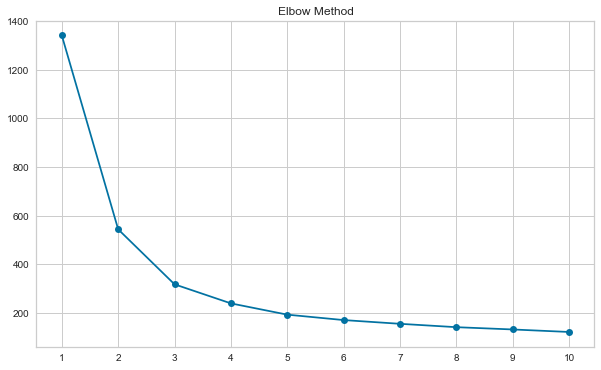

In [121]:
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(df_std.values)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.xticks(list(range(1, 11)))
plt.plot(range(1, 11), inertia, marker="o")
plt.title("Elbow Method")
plt.show()

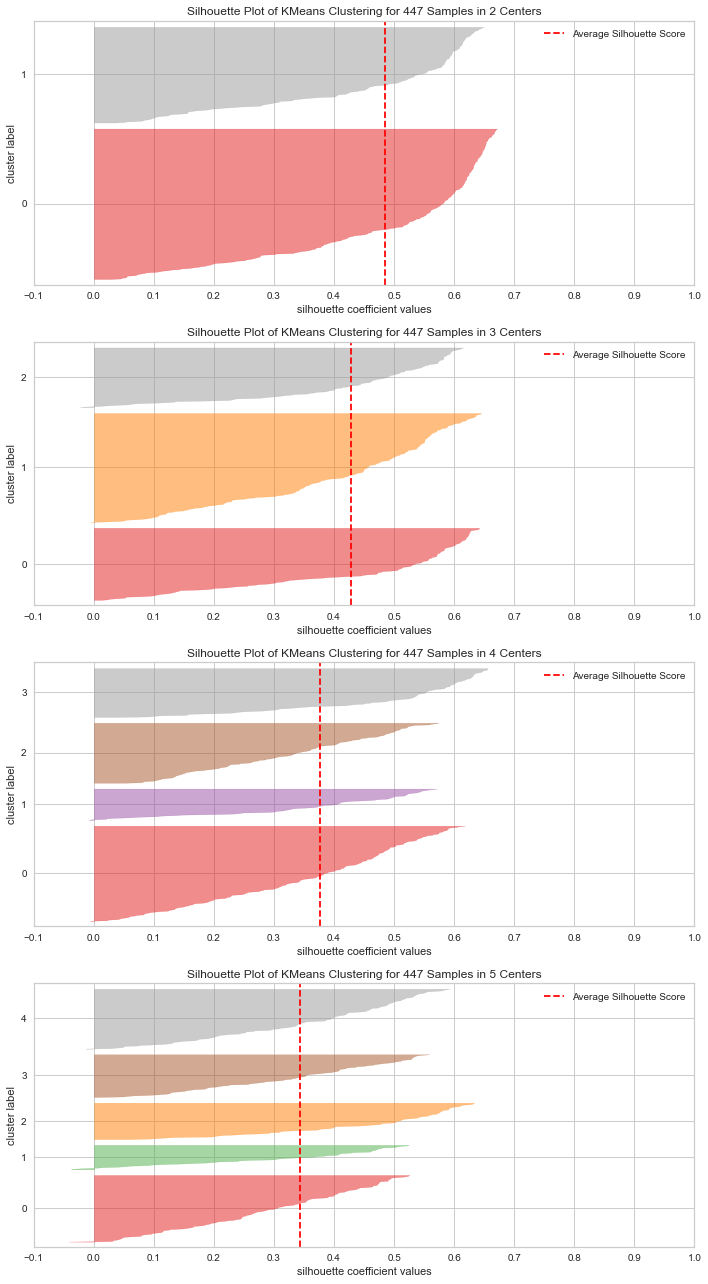

In [122]:
k_range = range(2, 6)
fig, axes = plt.subplots(4, 1, figsize=(10, 18))

for i in k_range:
    model = KMeans(i, init="k-means++", n_init=100, random_state=42)
    visualizer = SilhouetteVisualizer(model, ax=axes[i - 2])
    visualizer.fit(df_std.values)
    visualizer.finalize()
    axes[i - 2].set_xlim(-0.1, 1)

plt.tight_layout()

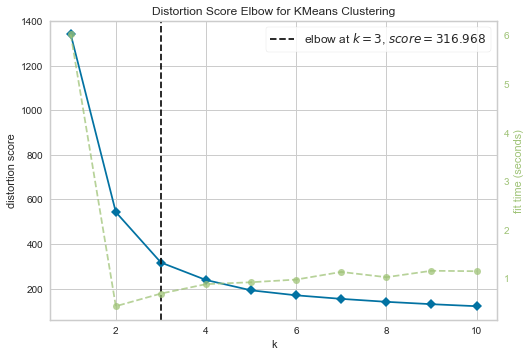

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [123]:
Elbow_M = KElbowVisualizer(
    KMeans(init="k-means++", n_init=100, random_state=42), k=((1, 11))
)
Elbow_M.fit(df_std)
Elbow_M.show()


In [124]:
kmeans_3 = KMeans(n_clusters=3, init="k-means++", n_init=100, random_state=42)
kmeans_3.fit(X_std)

df_cl3 = pd.DataFrame(data=X_std, columns=df_clust.columns)
df_cl3["cluster"] = kmeans_3.labels_
df_cl3.sample(3)

,transactionid,qty,totalamount,cluster
406,-0.688048,-1.171730,-0.956765,0
64,-0.688048,-0.622383,-1.170429,0
310,0.545884,1.261093,0.879456,2


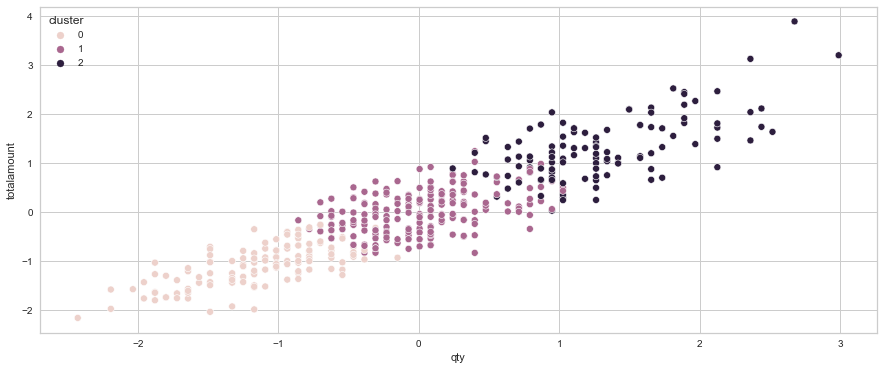

In [125]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x="qty", y="totalamount", data=df_cl3, hue="cluster")
plt.show()

In [126]:
print(silhouette_score(X_std, kmeans_3.labels_))
print(davies_bouldin_score(X_std, kmeans_3.labels_))

0.4286978484494183
0.7493899873949225


In [127]:
print(silhouette_score(df_clust, kmeans_3.labels_))
print(davies_bouldin_score(df_clust, kmeans_3.labels_))

0.4004187239970804
0.6561286170311996


# PCA

In [128]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X_std)
pca_df = pd.DataFrame.from_records(data=pca_data, columns=["x1", "x2"])
kmeans_pca = KMeans(n_clusters=3, init="k-means++", n_init=100, random_state=42)
kmeans_pca.fit(pca_data)
pca_df["cluster"] = kmeans_pca.labels_

In [129]:
pca_df.head()

,x1,x2,cluster
0,3.099734,-0.090614,0
1,1.184631,0.006767,0
2,1.742079,0.278255,0
3,-0.264103,-0.129827,2
4,-1.818848,-0.367350,1


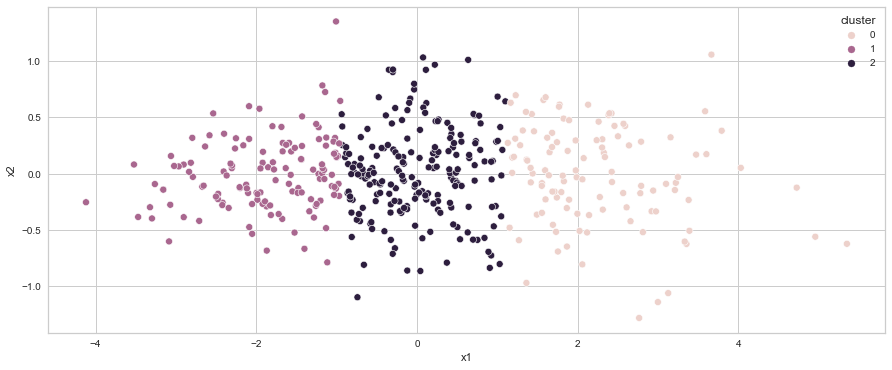

In [130]:
plt.figure(figsize=(15,6))
sns.scatterplot(x="x1", y="x2", data=pca_df, hue='cluster')
plt.show()

In [131]:
x1 = pca_df.drop(columns='cluster')
y1 = pca_df['cluster']

In [132]:
print(silhouette_score(x1, y1))
print(davies_bouldin_score(x1, y1))


0.4692791551652978
0.6722926953463069


In [133]:
print(silhouette_score(df_clust, y1))
print(davies_bouldin_score(df_clust, y1))

0.4018168057614836
0.6544399522295724


# Note:
1. Tujuan Silhouette Score adalah untuk mendapatkan nilai yang tinggi, mendekati 1, yang menandakan bahwa klaster adalah "padat" dan berbeda secara signifikan dari klaster lain. Sebaliknya, nilai negatif mendekati -1 menandakan bahwa objek lebih cenderung ditempatkan dalam klaster yang salah, dan nilai dekat 0 menandakan bahwa objek berada di dekat batas klaster.
2. Tujuan Davies-Bouldin Score adalah untuk mendapatkan nilai yang rendah, mendekati nol, yang menandakan bahwa klaster memiliki batas yang jelas dan terpisah satu sama lain, dan centroid berada cukup dekat dengan anggota klaster. Semakin rendah nilai skornya, semakin baik kualitas klasteringnya.

# RFM Analysis

In [134]:
today_date = dt.datetime(2023, 1, 1)
rfm = data.groupby("customerid").agg(
    {
        "date": lambda x: (today_date - x.max()).days,
        "transactionid": "count",
        "totalamount": "sum",
    }
)

rfm.rename(
    columns={
        "date": "Recency",
        "transactionid": "Frequency",
        "totalamount": "Monetary",
    },
    inplace=True,
)
rfm.head()

,Recency,Frequency,Monetary
customerid,,,
1,53,17,623300
2,97,13,392300
3,10,15,446200
4,5,10,302500
5,91,7,268600


In [135]:
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_quartiles = pd.qcut(rfm["Recency"], q=4, labels=r_labels)
f_quartiles = pd.qcut(rfm["Frequency"], q=4, labels=f_labels)
m_quartiles = pd.qcut(rfm["Monetary"], q=4, labels=m_labels)

rfm = rfm.assign(R=r_quartiles, F=f_quartiles, M=m_quartiles)
rfm.head()

,Recency,Frequency,Monetary,R,F,M
customerid,,,,,,
1,53,17,623300,1,4,4
2,97,13,392300,1,3,3
3,10,15,446200,3,4,4
4,5,10,302500,4,2,2
5,91,7,268600,1,1,1


In [136]:
def seg(dataf):
    """seg

    Args:
        data (dataframe): dataframe have value retency, frequency, and monetary

    Returns:
        sum of string values from RFM: combine values from value r, f, and m
    """
    return str(dataf["R"]) + str(dataf["F"]) + str(dataf["M"])


rfm["RFM"] = rfm.apply(seg, axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM
customerid,,,,,,,
1,53,17,623300,1,4,4,144
2,97,13,392300,1,3,3,133
3,10,15,446200,3,4,4,344
4,5,10,302500,4,2,2,422
5,91,7,268600,1,1,1,111


In [137]:
rfm["RFM_Score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score
customerid,,,,,,,,
1,53,17,623300,1,4,4,144,9
2,97,13,392300,1,3,3,133,7
3,10,15,446200,3,4,4,344,11
4,5,10,302500,4,2,2,422,8
5,91,7,268600,1,1,1,111,3


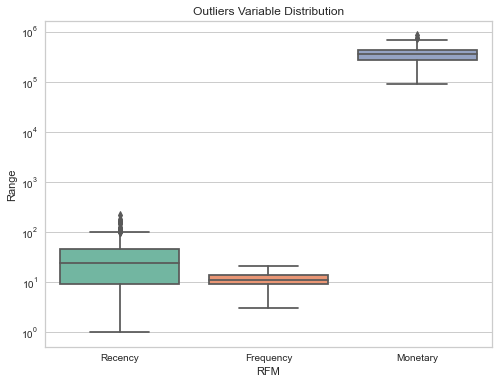

In [138]:
x = ["Recency", "Frequency", "Monetary"]
f, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(data=rfm[x], palette="Set2")
plt.yscale("log")
plt.title("Outliers Variable Distribution", fontsize=12)
plt.xlabel("RFM")
plt.ylabel("Range")
plt.show()

In [139]:
rfm.reset_index(inplace=True)
rfm.tail()

,customerid,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score
442,443,63,16,485100,1,4,4,144,9
443,444,38,18,577700,2,4,4,244,10
444,445,42,18,587200,2,4,4,244,10
445,446,11,11,423300,3,2,3,323,8
446,447,26,13,439300,2,3,3,233,8


In [140]:
def segments(dataf):
    """segment

    Args:
        data (dataframe): contain value of RFM score from dataframe

    Returns:
        string: value from segmentation based on rfm score
    """
    if dataf["RFM_Score"] > 10:
        return "champions"

    if (dataf["RFM_Score"] > 8) and (dataf["RFM_Score"] <= 10):
        return "potential_loyalists"

    if dataf["RFM_Score"] == 8:
        return "need_attention"

    if dataf["RFM_Score"] == 7:
        return "about_to_sleep"

    if (dataf["RFM_Score"] > 4) and (dataf["RFM_Score"] < 7):
        return "at_risk"

    return "hibernating"


rfm["Segment"] = rfm.apply(segments, axis=1)
rfm.head()

,customerid,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,Segment
0,1,53,17,623300,1,4,4,144,9,potential_loyalists
1,2,97,13,392300,1,3,3,133,7,about_to_sleep
2,3,10,15,446200,3,4,4,344,11,champions
3,4,5,10,302500,4,2,2,422,8,need_attention
4,5,91,7,268600,1,1,1,111,3,hibernating


In [141]:
rfm.groupby(["Segment"]).agg(
    {
        "customerid": "count",
        "Recency": "mean",
        "Frequency": "mean",
        "Monetary": "mean",
        "RFM_Score": "mean",
    }
).sort_values(by="RFM_Score", ascending=False).round(2)

,customerid,Recency,Frequency,Monetary,RFM_Score
Segment,,,,,
champions,58,9.16,15.74,527875.86,11.33
potential_loyalists,92,20.59,13.83,449896.74,9.49
need_attention,56,25.32,11.55,387846.43,8.00
about_to_sleep,67,31.21,10.82,355435.82,7.00
at_risk,103,36.83,9.14,278324.27,5.57
hibernating,71,69.23,7.35,223023.94,3.51


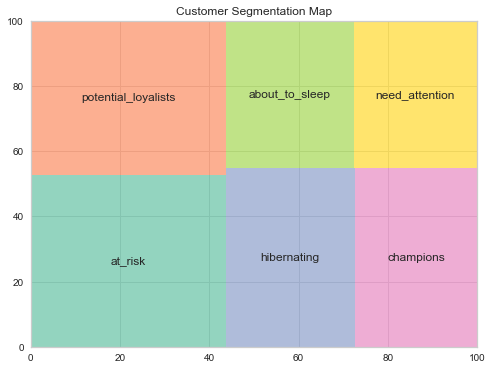

In [142]:
segments = rfm["Segment"].value_counts(normalize=True).sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(8, 6)

squarify.plot(
    sizes=segments,
    label=[
        "at_risk",
        "potential_loyalists",
        "hibernating",
        "champions",
        "about_to_sleep",
        "need_attention",
    ],
    color=sns.color_palette("Set2"),
    bar_kwargs={"alpha": 0.7},
)
plt.title("Customer Segmentation Map", fontsize=12)
plt.show()

In [143]:
print(" RFM Model Evaluation ".center(70, "="))
X = rfm[["Recency", "Frequency"]]
labels = rfm["Segment"]
print(f"Number of Observations: {X.shape[0]}")
print(f"Number of Segments: {labels.nunique()}")
print(f"Silhouette Score: {round(silhouette_score(X, labels), 3)}")
print(f'Davies Bouldin Score: {round(davies_bouldin_score(X, labels), 3)} \n{70*"="}')

======================== RFM Model Evaluation ========================
Number of Observations: 447
Number of Segments: 6
Silhouette Score: -0.173
Davies Bouldin Score: 5.103 


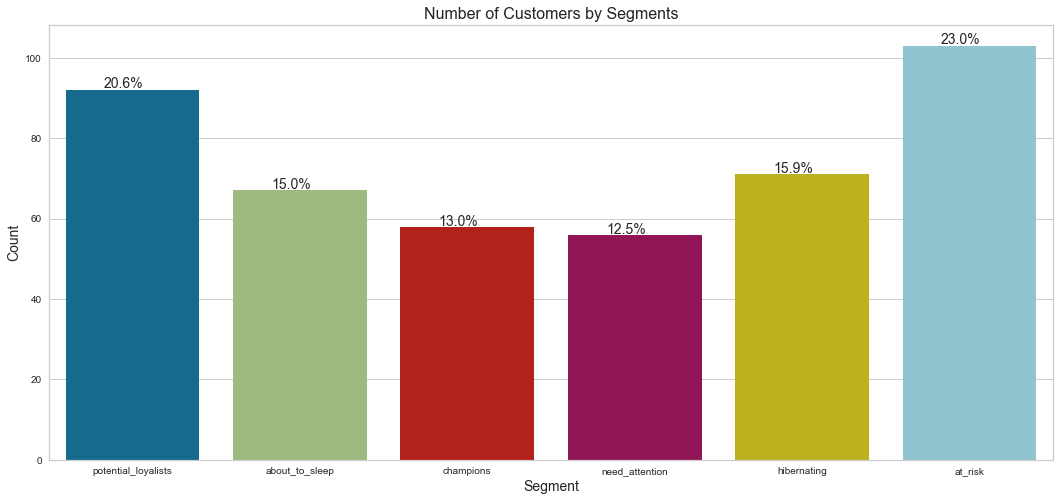

In [144]:
plt.figure(figsize=(18, 8))
ax = sns.countplot(data=rfm, x="Segment")
total = len(rfm.Segment)
for patch in ax.patches:
    FORMULA = (100 * patch.get_height() / total)
    PERCENTAGE = f"{FORMULA:.1f}%"
    x = patch.get_x() + patch.get_width() / 2 - 0.17
    y = patch.get_y() + patch.get_height() * 1.005
    ax.annotate(PERCENTAGE, (x, y), size=14)
plt.title("Number of Customers by Segments", size=16)
plt.xlabel("Segment", size=14)
plt.ylabel("Count", size=14)
plt.xticks(size=10)
plt.yticks(size=10)
plt.show()

In [145]:
rfm_RFM = rfm[["Recency", "Frequency", "Monetary"]]

scaler = StandardScaler()
rfm_standard = scaler.fit_transform(rfm_RFM)
rfm_standard = pd.DataFrame(rfm_standard)
rfm_standard.columns = ["Recency", "Frequency", "Monetary"]
rfm_standard.head()

,Recency,Frequency,Monetary
0,0.630690,1.779816,2.094768
1,2.001494,0.545884,0.239269
2,-0.708960,1.162850,0.672218
3,-0.864733,-0.379565,-0.482047
4,1.814566,-1.305014,-0.754347


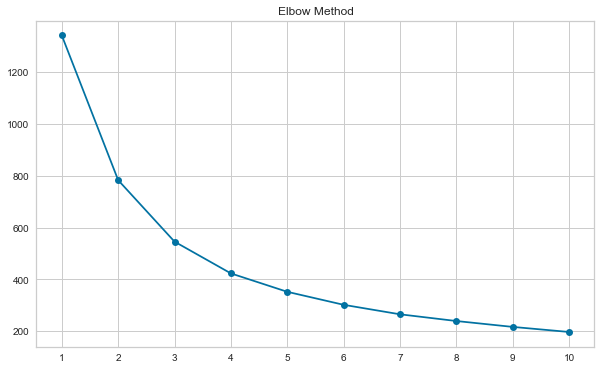

In [146]:
inertia = []

for i in range(1, 11):
    kmeans_6 = KMeans(n_clusters=i, init="k-means++", n_init=100, random_state=42)
    kmeans_6.fit(rfm_standard)
    inertia.append(kmeans_6.inertia_)

plt.figure(figsize=(10, 6))
plt.xticks(list(range(1, 11)))
plt.plot(range(1, 11), inertia, marker="o")
plt.title("Elbow Method")
plt.show()


In [147]:
kmeans_rfm = KMeans(n_clusters=3, init="k-means++", n_init=100, random_state=42)
kmeans_rfm.fit(rfm_standard)
cluster_labels = kmeans_rfm.labels_

In [148]:
rfm_k3 = rfm.assign(Cluster=cluster_labels)
rfm_k3.head()

,customerid,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,Segment,Cluster
0,1,53,17,623300,1,4,4,144,9,potential_loyalists,2
1,2,97,13,392300,1,3,3,133,7,about_to_sleep,1
2,3,10,15,446200,3,4,4,344,11,champions,2
3,4,5,10,302500,4,2,2,422,8,need_attention,0
4,5,91,7,268600,1,1,1,111,3,hibernating,1


In [149]:
rfm_k3.groupby("Cluster").agg(
    {"Recency": "mean", "Frequency": "mean", "Monetary": "mean", "RFM_Score": "mean"}
).round(1)

,Recency,Frequency,Monetary,RFM_Score
Cluster,,,,
0,21.1,9.6,294908.7,6.4
1,91.9,8.4,269807.7,4.2
2,24.8,14.5,489118.3,9.8


In [150]:
rfm.groupby(["Segment"]).agg(
    {
        "customerid": "count",
        "Recency": "mean",
        "Frequency": "mean",
        "Monetary": "mean",
        "RFM_Score": "mean",
    }
).sort_values(by="RFM_Score", ascending=False)

,customerid,Recency,Frequency,Monetary,RFM_Score
Segment,,,,,
champions,58,9.155172,15.741379,527875.862069,11.327586
potential_loyalists,92,20.586957,13.826087,449896.739130,9.489130
need_attention,56,25.321429,11.553571,387846.428571,8.000000
about_to_sleep,67,31.208955,10.820896,355435.820896,7.000000
at_risk,103,36.825243,9.135922,278324.271845,5.572816
hibernating,71,69.225352,7.352113,223023.943662,3.507042


In [151]:
rfm_k3.groupby(["Cluster", "Segment"]).agg(
    {"customerid": "count", "RFM_Score": "mean"}
).round(2)

customerid  RFM_Score
Cluster Segment                                   
0       about_to_sleep               50       7.00
        at_risk                      80       5.62
        hibernating                  32       3.84
        need_attention               35       8.00
        potential_loyalists          21       9.19
1       about_to_sleep                4       7.00
        at_risk                      22       5.36
        hibernating                  39       3.23
2       about_to_sleep               13       7.00
        at_risk                       1       6.00
        champions                    58      11.33
        need_attention               21       8.00
        potential_loyalists          71       9.58

In [152]:
rfm_standard["customerid"] = rfm["customerid"]
rfm_standard = rfm_standard.assign(Cluster=cluster_labels)
rfm_standard.head()

,Recency,Frequency,Monetary,customerid,Cluster
0,0.630690,1.779816,2.094768,1,2
1,2.001494,0.545884,0.239269,2,1
2,-0.708960,1.162850,0.672218,3,2
3,-0.864733,-0.379565,-0.482047,4,0
4,1.814566,-1.305014,-0.754347,5,1


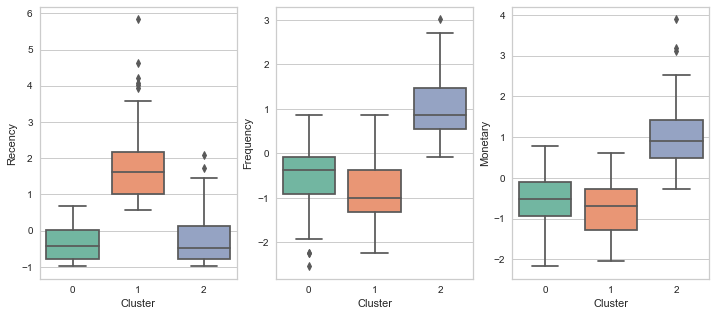

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

sns.boxplot(data=rfm_standard, x="Cluster", y="Recency", palette="Set2", ax=axes[0])
sns.boxplot(data=rfm_standard, x="Cluster", y="Frequency", palette="Set2", ax=axes[1])
sns.boxplot(data=rfm_standard, x="Cluster", y="Monetary", palette="Set2", ax=axes[2])

plt.show()

In [154]:
rfm_k3.head()

,customerid,Recency,Frequency,Monetary,R,F,M,RFM,RFM_Score,Segment,Cluster
0,1,53,17,623300,1,4,4,144,9,potential_loyalists,2
1,2,97,13,392300,1,3,3,133,7,about_to_sleep,1
2,3,10,15,446200,3,4,4,344,11,champions,2
3,4,5,10,302500,4,2,2,422,8,need_attention,0
4,5,91,7,268600,1,1,1,111,3,hibernating,1


In [155]:
rfm_standard.head()

,Recency,Frequency,Monetary,customerid,Cluster
0,0.630690,1.779816,2.094768,1,2
1,2.001494,0.545884,0.239269,2,1
2,-0.708960,1.162850,0.672218,3,2
3,-0.864733,-0.379565,-0.482047,4,0
4,1.814566,-1.305014,-0.754347,5,1


<Figure size 1080x432 with 0 Axes>

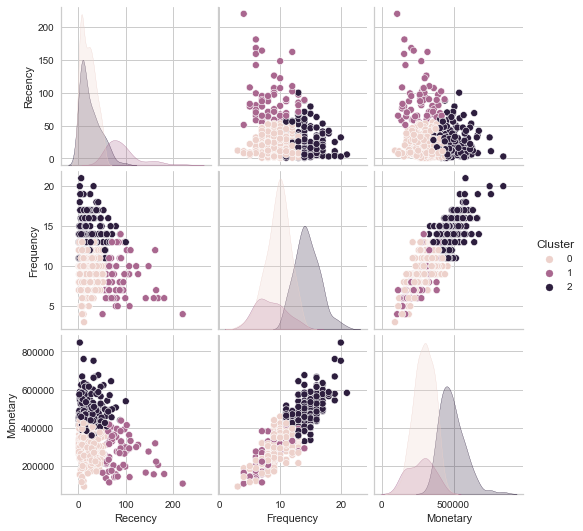

In [156]:
rfm_k4 = rfm_k3.drop(columns=["customerid", "RFM_Score"])
plt.figure(figsize=(15, 6))
sns.pairplot(data=rfm_k4, hue="Cluster")
plt.show()

In [157]:
x2 = rfm_standard.drop(columns=["customerid", "Cluster"])
y2 = rfm_standard["Cluster"]

print(silhouette_score(x2, y2))
print(davies_bouldin_score(x2, y2))

0.37182992514967267
0.9363383498746344


In [158]:
x3 = rfm_k3.drop(columns=["customerid", "Cluster", "Segment"])
y3 = rfm_k3["Cluster"]

print(silhouette_score(x3, y3))
print(davies_bouldin_score(x3, y3))

0.2024288516604988
3.652656821035737


# Cohort Analysis

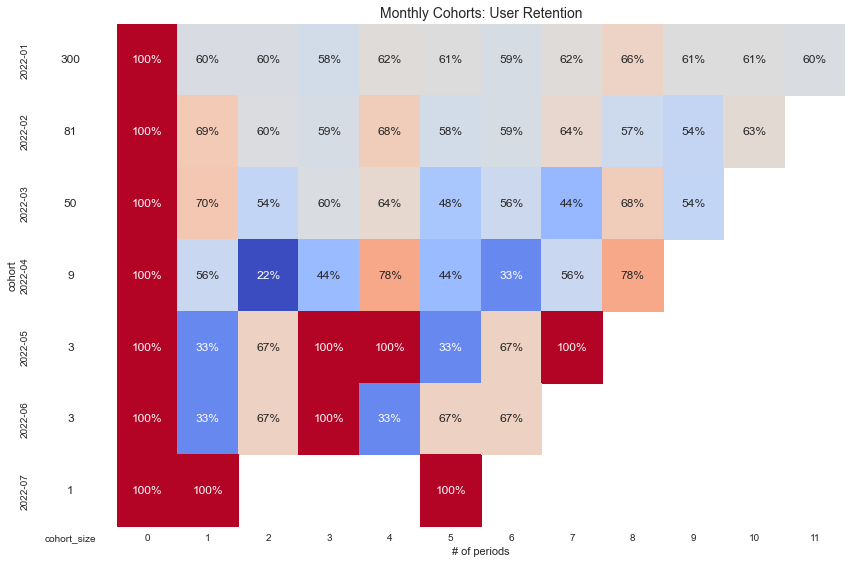

In [159]:
def cohort_analysis(dataframe):
    """cohort_analysis

    Args:
        dataframe (pd.Dataframe): contain all information from dataset
    """
    daf = dataframe.copy()
    daf = daf[["customerid", "transactionid", "date"]].drop_duplicates()
    daf["order_month"] = daf["date"].dt.to_period("M")
    daf["cohort"] = (
        daf.groupby("customerid")["date"].transform("min").dt.to_period("M")
    )
    cohort_data = (
        daf.groupby(["cohort", "order_month"])
        .agg(n_customers=("customerid", "nunique"))
        .reset_index(drop=False)
    )
    cohort_data["period_number"] = (cohort_data.order_month - cohort_data.cohort).apply(
        attrgetter("n")
    )
    cohort_pivot = cohort_data.pivot_table(
        index="cohort", columns="period_number", values="n_customers"
    )
    cohort_size = cohort_pivot.iloc[:, 0]
    retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
    with sns.axes_style("white"):
        fig1, ax1 = plt.subplots(
            1, 2, figsize=(12, 8), sharey=True, gridspec_kw={"width_ratios": [1, 11]}
        )
        sns.heatmap(
            retention_matrix,
            mask=retention_matrix.isnull(),
            annot=True,
            cbar=False,
            fmt=".0%",
            cmap="coolwarm",
            ax=ax1[1],
        )
        ax1[1].set_title("Monthly Cohorts: User Retention", fontsize=14)
        ax1[1].set(xlabel="# of periods", ylabel="")
        white_cmap = mcolors.ListedColormap(["white"])
        sns.heatmap(
            pd.DataFrame(cohort_size).rename(columns={0: "cohort_size"}),
            annot=True,
            cbar=False,
            fmt="g",
            cmap=white_cmap,
            ax=ax1[0],
        )
        fig1.tight_layout()


cohort_analysis(data)


# Market Basket Analysis

In [160]:
def create_transaction_product_df(dataframe):
    """create_invoice_product_df

    Args:
        dataframe (pd.Dataframe): contain all information from dataset

    Returns:
        pd.Dataframe: group value transactionid and product_name based on quantity
    """
    return (
        dataframe.groupby(["transactionid", "product_name"])["qty"]
        .sum()
        .unstack()
        .fillna(0)
        .applymap(lambda x: 1 if x > 0 else 0)
    )


pro_df = create_transaction_product_df(data)
pro_df.head()

product_name,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
transactionid,,,,,,,,,,
TR10008,0,0,0,0,0,0,1,0,0,0
TR10012,0,0,0,0,0,0,0,0,0,1
TR10026,1,0,0,0,0,0,0,0,0,0
TR10049,0,0,0,0,0,0,0,1,0,0
TR10055,0,1,0,0,0,0,0,0,0,0


In [161]:
frequent_itemsets = apriori(pro_df, min_support=0.01, use_colnames=True)
frequent_itemsets.sort_values("support", ascending=False)

,support,itemsets
8,0.165648,(Thai Tea)
1,0.125917,(Cheese Stick)
5,0.107783,(Ginger Candy )
3,0.106357,(Coffee Candy)
4,0.104727,(Crackers)
9,0.099226,(Yoghurt)
6,0.098411,(Oat)
2,0.080888,(Choco Bar)
7,0.079258,(Potato Chip)
0,0.051752,(Cashew)
